In [19]:
#import libraries and packages

import numpy as np
import pandas as pd
import string
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import spatial
%matplotlib inline
import warnings # supress warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
import nltk
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import re
from numpy import array
from numpy import asarray
from numpy import zeros

from sklearn.manifold import TSNE

In [2]:
#loading dataset

print('Loading Dataset ......')

dev_data =pd.read_json('train_spider.json')

#set a readable columnm width
pd.set_option("display.max_colwidth", -1)

Loading Dataset ......


In [3]:
dev_data['processed_Question'] = dev_data['question'].str.replace('[^\w\s]','')
dev_data['processed_Question'] = dev_data['processed_Question'].str.lower()

In [4]:
dev_data['processed_Query'] = dev_data['query'].str.lower()

In [5]:
processed_Col = dev_data[['processed_Question', 'processed_Query']]
train = processed_Col.copy()

In [6]:
train.head()

,processed_Question,processed_Query
0,how many heads of the departments are older than 56,select count(*) from head where age > 56
1,list the name born state and age of the heads of departments ordered by age,"select name , born_state , age from head order by age"
2,list the creation year name and budget of each department,"select creation , name , budget_in_billions from department"
3,what are the maximum and minimum budget of the departments,"select max(budget_in_billions) , min(budget_in_billions) from department"
4,what is the average number of employees of the departments whose rank is between 10 and 15,select avg(num_employees) from department where ranking between 10 and 15


Processing the query text

In [10]:
input_sentences = train['processed_Question']
output_sentences = train['processed_Query'].astype(str) + ' <end>'
output_sentences_inputs = '<start> ' + train['processed_Query'].astype(str)

In [11]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 7000
num samples output: 7000
num samples output input: 7000


In [51]:
print(input_sentences[6852])
print(output_sentences[3408])
print(output_sentences_inputs[6852])

what is the number of cities in the united states with more than 3 airports
select first_name ,  last_name ,  salary from employees where salary  <  6000 <end>
<start> select city from airports where country  =  'united states' group by city having count(*)  >  3


TOKENIZATION

In [13]:
max_features = 20000 # this is the number of words we care about

input_tokenizer = Tokenizer(num_words=max_features,split = ' ', oov_token='<unw>',filters='')
input_tokenizer.fit_on_texts(input_sentences)

# this takes our sentences and replaces each word with an integer
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

#finds out the unique words in the input sentences
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))


max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)


Total unique words in the input: 3066
Length of longest sentence in input: 38


In [14]:
#tokenizer for the output 
output_tokenizer = Tokenizer(num_words=max_features, oov_token='<unw>', split = ' ',filters='')
output_tokenizer.fit_on_texts(output_sentences_inputs + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)

output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

# this takes our input sentences of the decoder and replaces each word with an integer
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)

print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 6793
Length of longest sentence in the output: 88


`PADDING

In [15]:
#settling the maximum padding length

sequence_length_input = 38
sequence_length_output = 88

In [16]:
# we then pad the sequences so they're all the same length (sequence_length)
encoder_input_sequences = pad_sequences(input_integer_seq, sequence_length_input )
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

# we then pad the sequences so they're all the same length (sequence_length)
decoder_input_sequences = pad_sequences(output_input_integer_seq, sequence_length_output, padding='post' )

print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

encoder_input_sequences.shape: (7000, 38)
encoder_input_sequences[172]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4
   6   2   8   3  11 150  12  16  36  22 160 697 329   5   6  37 178   7
 327 696]
decoder_input_sequences.shape: (7000, 88)
decoder_input_sequences[172]: [   9    5   25    2   93    4   13    7  200    4   14    8   38    3
  455   16   11  455   29 1304   21  283   44    5   23    2   93    6
   43    3  307 2663    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [17]:
# we then pad the sequences so they're all the same length (sequence_length)
decoder_output_sequences = pad_sequences(output_integer_seq, sequence_length_output, padding='post' )

print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[172]:", decoder_output_sequences[172])

decoder_output_sequences.shape: (7000, 88)
decoder_output_sequences[172]: [   5   25    2   93    4   13    7  200    4   14    8   38    3  455
   16   11  455   29 1304   21  283   44    5   23    2   93    6   43
    3  307 2663   10    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


WORD EMBEDDINGS USING GLOVE

In [20]:
embeddings_dictionary = dict()

#using the 100 words dictionary of glove downloaded from the standford website
glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [21]:
#Scatter pltting TSNE to find the nearest cluster in the dictionary with the help of euclidean distance

def find_closest_embeddings(embedding):
    return sorted(embeddings_dictionary.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dictionary[word], embedding))

print(find_closest_embeddings(embeddings_dictionary["king"])[1:6])

['prince', 'queen', 'monarch', 'brother', 'uncle']


In [22]:
print(find_closest_embeddings(embeddings_dictionary["twig"] - embeddings_dictionary["branch"] + embeddings_dictionary["hand"])[:5])

['flashlight', 'twig', 'clipboard', 'shove', 'hand']


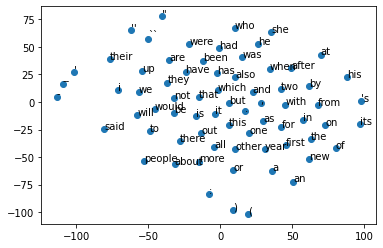

In [23]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dictionary.keys())
vectors = [embeddings_dictionary[word] for word in words]
Y = tsne.fit_transform(vectors[:70]) # first 70 sentences, as the cluster was not readbale so reduced the size

plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

In [33]:
#defining the hyper parameters

LSTM_NODES =256
BATCH_SIZE = 64
EPOCHS = 20
EMBEDDING_SIZE = 100

In [24]:
#creating embedding matrix for the embedding layer of LSTM


num_words = min(max_features, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [26]:
# to create empty output array by performing one hot encoding on the target array
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [27]:
decoder_targets_one_hot.shape

(7000, 88, 6794)

In [28]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

Defining Encoder

In [30]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

#passing in the embedded lauer to the hidden and cell states
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

Defining Decoder

In [31]:
#Model Creation for decoder

decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [32]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
#epochs = 20

r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/20
88/88 [==============================] - 108s 1s/step - loss: 0.8393 - accuracy: 0.8582 - val_loss: 0.8170 - val_accuracy: 0.8768
Epoch 2/20
88/88 [==============================] - 113s 1s/step - loss: 0.6239 - accuracy: 0.8959 - val_loss: 0.7337 - val_accuracy: 0.9050
Epoch 3/20
88/88 [==============================] - 113s 1s/step - loss: 0.5287 - accuracy: 0.9089 - val_loss: 0.7185 - val_accuracy: 0.9111
Epoch 4/20
88/88 [==============================] - 111s 1s/step - loss: 0.4850 - accuracy: 0.9139 - val_loss: 0.7235 - val_accuracy: 0.9124
Epoch 5/20
88/88 [==============================] - 118s 1s/step - loss: 0.4553 - accuracy: 0.9175 - val_loss: 0.6867 - val_accuracy: 0.9159
Epoch 6/20
88/88 [==============================] - 109s 1s/step - loss: 0.4288 - accuracy: 0.9217 - val_loss: 0.6877 - val_accuracy: 0.9168
Epoch 7/20
88/88 [==============================] - 116s 1s/step - loss: 0.4010 - accuracy: 0.9254 - val_loss: 0.6737 - val_accuracy: 0.9200
Epoch 8/20
88

Accuracy 97% and loss of 11% noted down after 20 epochs

In [37]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

Setting up the decoding layer and model creation

In [38]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [39]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [40]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_outputs, h, c

(<KerasTensor: shape=(None, 1, 256) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_1')>)

In [41]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_outputs.shape

TensorShape([None, 1, 6794])

In [42]:
#creating the model by passing in the deocder input, hidden and state cells
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [43]:
#converting the index to word vectorization to obtain the target text

idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [47]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<start>']
    end = word2idx_outputs['<end>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if end == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            

        target_seq[0, 0] = idx
        states_value = [h, c]

    return output_sentence

In [50]:
i = np.random.choice(len(input_sentences)) # picking a random number to pass to the input
print(i)
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)

print('Question:', input_sentences[i])
print('Predicted SQL Query:', ' '.join(translation))

3408
Question: what are the full names and salaries for any employees earning less than 6000
Predicted SQL Query: select first_name , last_name , salary from employees where salary > ( select min(salary) from employees where first_name = "clara") and department_id where department_id = 'researcher' )


Example output of the model

ID = 2724

Question = what are the full names and salaries for any employees earning less than 6000

SQL Query = select first_name ,  last_name ,  salary from employees where salary  <  6000

Predicted SQL Query = select first_name , last_name , salary from employees where salary > ( select min(salary) from employees where first_name = "clara") and department_id where department_id = 'researcher' )

In [52]:
idx2word_target

{1: '<unw>',
 2: 'from',
 3: '=',
 4: 'as',
 5: 'select',
 6: 'where',
 7: 'join',
 8: 'on',
 9: '<start>',
 10: '<end>',
 11: 'by',
 12: ',',
 13: 't1',
 14: 't2',
 15: 'count(*)',
 16: 'group',
 17: 'order',
 18: 'limit',
 19: 'desc',
 20: 't3',
 21: '>',
 22: 'and',
 23: 'name',
 24: '1',
 25: 't1.name',
 26: '1select',
 27: 'distinct',
 28: '(select',
 29: 'having',
 30: 'student',
 31: 't2.name',
 32: 'customers',
 33: '<',
 34: 'in',
 35: 't1.customer_id',
 36: 'count(distinct',
 37: 'intersect',
 38: 't1.id',
 39: '>=',
 40: 'products',
 41: 'not',
 42: 't2.customer_id',
 43: 'city',
 44: 'except',
 45: 'or',
 46: 'country',
 47: 'year',
 48: 'employees',
 49: 'like',
 50: 't3.name',
 51: 'age',
 52: 'asc',
 53: 'people',
 54: 'department',
 55: 'title',
 56: 'player',
 57: 'location',
 58: '!=',
 59: 't2.id',
 60: 'course',
 61: 'first_name',
 62: 'salary',
 63: '2',
 64: 'college',
 65: 'artist',
 66: 'faculty',
 67: 'staff',
 68: 'party',
 69: 'song',
 70: 'employee',
 71: 's

In [53]:
word2idx_outputs

{'<unw>': 1,
 'from': 2,
 '=': 3,
 'as': 4,
 'select': 5,
 'where': 6,
 'join': 7,
 'on': 8,
 '<start>': 9,
 '<end>': 10,
 'by': 11,
 ',': 12,
 't1': 13,
 't2': 14,
 'count(*)': 15,
 'group': 16,
 'order': 17,
 'limit': 18,
 'desc': 19,
 't3': 20,
 '>': 21,
 'and': 22,
 'name': 23,
 '1': 24,
 't1.name': 25,
 '1select': 26,
 'distinct': 27,
 '(select': 28,
 'having': 29,
 'student': 30,
 't2.name': 31,
 'customers': 32,
 '<': 33,
 'in': 34,
 't1.customer_id': 35,
 'count(distinct': 36,
 'intersect': 37,
 't1.id': 38,
 '>=': 39,
 'products': 40,
 'not': 41,
 't2.customer_id': 42,
 'city': 43,
 'except': 44,
 'or': 45,
 'country': 46,
 'year': 47,
 'employees': 48,
 'like': 49,
 't3.name': 50,
 'age': 51,
 'asc': 52,
 'people': 53,
 'department': 54,
 'title': 55,
 'player': 56,
 'location': 57,
 '!=': 58,
 't2.id': 59,
 'course': 60,
 'first_name': 61,
 'salary': 62,
 '2': 63,
 'college': 64,
 'artist': 65,
 'faculty': 66,
 'staff': 67,
 'party': 68,
 'song': 69,
 'employee': 70,
 'stuid